In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check, accuracy_check_iter, accuracy_check_err
import time

In [2]:
def decentralizedSGD(x0, lr, max_iter, eps, W, oracle):
    """
    Decentralized SGD Algorithm.

    Attributes
    ----------
    x0 : np.array[float]
        Initial point.
    lr : float
        Learning rate.
    max_iter : int
        Maximum number of iteration.
    eps: float
        Desired accuarcy.
    W : np.array[float]
        Mixing matrix.
    oracle : oracle.Oracle
        Oracle with acces to function and their gradient.
    
    Returns
    -------
    x_t : np.array[float]
        Solution coordinate.
    itr : int
        Final number of iterations.
    errors : np.array[float]
        List of accuracy for all steps.
    
    """
    
    x_t = x0
    x_prev = x0
    
    itr = 0
    error = np.inf
    current_sum = 0.
    
    errors = []
    
    x_star, f_star = oracle.getMin()
    
    while (itr < max_iter) and (error > eps):
         
        noise = np.random.normal(0, 1, size=x_t.shape) / 100
        
        f, df = oracle(x_t + noise)
        
        x_prev = x_t
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        '''
        if (oracle.getType() == "strongly convex") and (itr > 0):
            err, sum_ = accuracy_check_iter(x_prev, current_sum, itr, oracle, x_t)
            error = err
            current_sum = sum_
            errors.append(error)
        elif (oracle.getType() != "strongly convex"):
            err, sum_ = accuracy_check_iter(x_t, current_sum, itr, oracle)
            error = err
            current_sum = sum_
            errors.append(error)
        '''
        
        error = accuracy_check_err(x_t, x_star)    
        errors.append(error)
         
        itr += 1
        
    return x_t, itr, errors

def MetropolisHastings(W):
    """
    Metropolis Hastings Algorithm.

    Attributes
    ----------
    W : np.array[float]
        Adjacency matrix.

    Returns
    -------
    W : np.array[float]
        Mixing matrix
    """
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i+1, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = 1 / (1 + max(degrees[i], degrees[j]))
                
                W[i, j] = weight
                W[j, i] = weight
    
    for i in range(W.shape[0]):
        if W[i, i] != 0:
            W[i, i] = 1 - (np.sum(W, axis = 0)[i] - 1.0) # Remove 1 because counts self weight of 1 from adjacency matrix W
                
    return W


def toMatrix(n_nodes, adj_list):
    """
    Creating adjacency matrix.

    Attributes
    ----------
    n_nodes : int
        Number of nodes.
    adj_list : np.array[int]
        List of neighbors for every node

    Returns
    -------
    W : np.array[float]
        Adjacency matrix
    """
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    """
    Creating mixing matrix for different topology.

    Attributes
    ----------
    n_nodes : int
        Number of nodes.
    topology : str, options: ['dense', 'ring', 'centralized', 'path']
        Topology label.

    Returns
    -------
    W : np.array[float]
        Mixing matrix
    """
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))

        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [node, 0]
            else:
                connections[node] = [node, node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        connections[0] = [0]
        for node in range(1, n_nodes):
            connections[node] = [node, 0] # node 0 is central node
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "path":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node != n_nodes - 1:
                connections[node] = [node, node + 1]
            else:
                connections[node] = [node]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(list_nodes, n_params, topology, func_type, max_iter, lr, error_threshold, number_exp = 10):
    """
    Experiments for different umber of nodes.

    Attributes
    ----------
    list_nodes : list[int]
        Number of nodes.
    n_params :  int   
        Dimension for vector x.
    topology : str, options: ['dense', 'ring', 'centralized', 'path']
        Topology label.
    func_type : str, options: ['non convex', 'convex', 'strongly convex']
        Function class.
    max_iter : int
        Maximum iterations for DSGD algorithm.
    lr : float
        Learning rate.
    error_threshold : float
        Desired accuracy.
    number_exp :
        The number of experiments for every number of nodes. 
        Because of the stochastic component, it is important to analyze results using mean and variance.
    
    
    
    Returns
    -------
    means : np.array[float]
        List of mean number of iteration per number of modes.
    results : np.array[float]
        Logs for all number of iterations for every number of nodes.
    """
    
    means = []
    results = []
    
    oracle = Oracle(func_type, n_params)
    
    for n_nodes in list_nodes:
        start = time.time()
        
        print("Starting experiment on {} nodes.".format(n_nodes))
        
        temp = []
        
        for _ in range(number_exp): # Do average
            
            x0 = np.ones((n_params, n_nodes)).astype(np.float64) #np.random.randn(n_params, n_nodes)
            W = buildTopology(n_nodes, topology)
            
            x_t, itr, errors = decentralizedSGD(x0, lr, max_iter, error_threshold, W, oracle)

            temp.append(itr)
        
        mean = np.mean(temp)
        
        print(f'DEBUG num.nides {n_nodes} time {time.time() - start}')
        print("Converged within {} in {} iterations on average.".format(error_threshold, mean))
        print()
        
        means.append(mean)
        results.append(temp)
    
    return np.array(means), np.array(results)
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

# Experiments

In [3]:
save_folder = "data/"

n_params = 8
max_iter = np.inf
number_exp = 3

num_nodes = [10, 50, 100, 300, 600, 1000]

## Non convex function

In [4]:
func_type = "non convex"

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.1362919807434082
Converged within 2e-05 in 670.6666666666666 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.1503441333770752
Converged within 2e-05 in 668.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.19712305068969727
Converged within 2e-05 in 668.6666666666666 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.7046329975128174
Converged within 2e-05 in 666.6666666666666 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 2.4587459564208984
Converged within 2e-05 in 668.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 6.292521953582764
Converged within 2e-05 in 668.3333333333334 iterations on average.



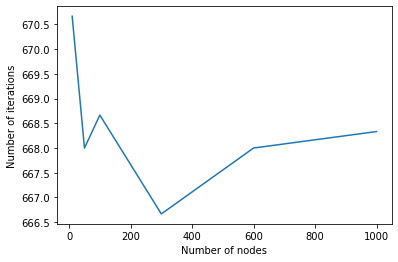

data/nonconvex_dense.npy


In [5]:
topology = "dense"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.13063812255859375
Converged within 2e-05 in 670.0 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.15442514419555664
Converged within 2e-05 in 668.6666666666666 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.20039105415344238
Converged within 2e-05 in 668.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.5222728252410889
Converged within 2e-05 in 667.6666666666666 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 1.6919937133789062
Converged within 2e-05 in 668.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 4.937232255935669
Converged within 2e-05 in 669.0 iterations on average.



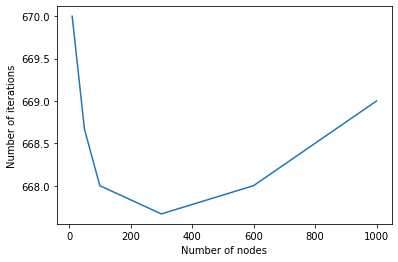

data/nonconvex_ring.npy


In [6]:
topology = "ring"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.13687872886657715
Converged within 2e-05 in 672.0 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.16870880126953125
Converged within 2e-05 in 672.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 0.21944403648376465
Converged within 2e-05 in 673.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 0.5437870025634766
Converged within 2e-05 in 676.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 1.6057400703430176
Converged within 2e-05 in 676.3333333333334 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 5.375617980957031
Converged within 2e-05 in 678.0 iterations on average.



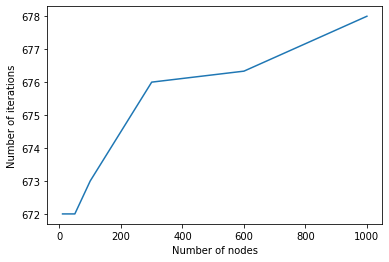

data/nonconvex_centralized.npy


In [7]:
topology = "centralized"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Convex function

In [8]:
func_type = "convex"

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 1.33197021484375
Converged within 0.005 in 1625.6666666666667 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 3.8322558403015137
Converged within 0.005 in 1626.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 7.925687074661255
Converged within 0.005 in 1625.6666666666667 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 34.31986713409424
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 59.33382511138916
Converged within 0.005 in 1627.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 133.52432799339294
Converged within 0.005 in 1626.6666666666667 iterations on average.



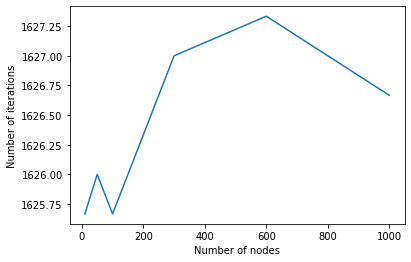

data/convex_dense.npy


In [9]:
topology = "dense"
lr = 1e-1
threshold = 5e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 4.426249027252197
Converged within 0.005 in 1631.0 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 6.58600926399231
Converged within 0.005 in 1626.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 9.446051836013794
Converged within 0.005 in 1627.3333333333333 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 40.2433819770813
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 60.407984256744385
Converged within 0.005 in 1626.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 104.00273108482361
Converged within 0.005 in 1626.6666666666667 iterations on average.



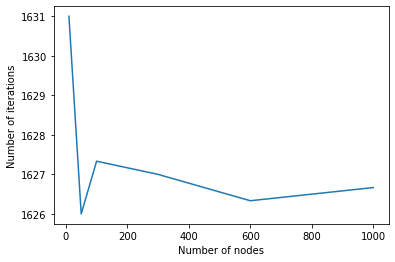

data/convex_ring.npy


In [10]:
topology = "ring"
lr = 1e-1
threshold = 5e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 1.6115150451660156
Converged within 0.005 in 1629.6666666666667 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 4.948440074920654
Converged within 0.005 in 1625.6666666666667 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 8.710062026977539
Converged within 0.005 in 1627.6666666666667 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 41.13915395736694
Converged within 0.005 in 1626.3333333333333 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 201.42973375320435
Converged within 0.005 in 1627.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 145.40423917770386
Converged within 0.005 in 1626.6666666666667 iterations on average.



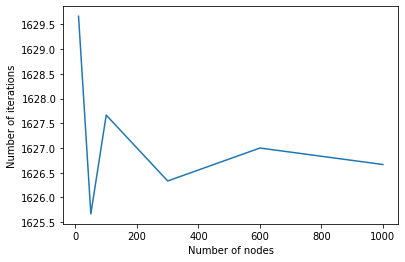

data/convex_centralized.npy


In [11]:
topology = "centralized"
lr = 1e-1
threshold = 5e-3

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

## Strongly convex function

In [12]:
func_type = "strongly convex"

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.30187106132507324
Converged within 2e-05 in 315.6666666666667 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.7637267112731934
Converged within 2e-05 in 318.6666666666667 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 1.3680009841918945
Converged within 2e-05 in 320.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 4.20242714881897
Converged within 2e-05 in 319.6666666666667 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 9.335742950439453
Converged within 2e-05 in 319.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 17.78118920326233
Converged within 2e-05 in 319.0 iterations on average.



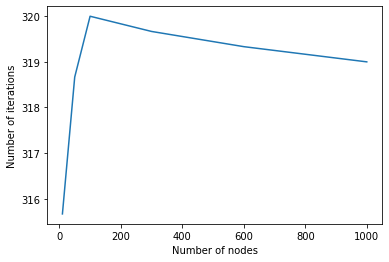

data/stronglyconvex_dense.npy


In [13]:
topology = "dense"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.30213379859924316
Converged within 2e-05 in 324.3333333333333 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.7754092216491699
Converged within 2e-05 in 320.0 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 1.3736202716827393
Converged within 2e-05 in 320.0 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 3.972280263900757
Converged within 2e-05 in 320.3333333333333 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 8.832770824432373
Converged within 2e-05 in 321.3333333333333 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 16.198559045791626
Converged within 2e-05 in 321.0 iterations on average.



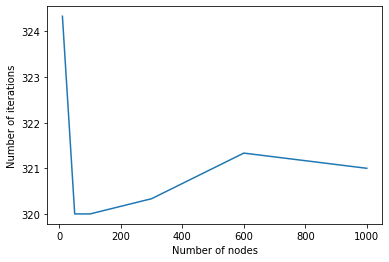

data/stronglyconvex_ring.npy


In [14]:
topology = "ring"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

Starting experiment on 10 nodes.
DEBUG num.nides 10 time 0.3198871612548828
Converged within 2e-05 in 322.3333333333333 iterations on average.

Starting experiment on 50 nodes.
DEBUG num.nides 50 time 0.8032069206237793
Converged within 2e-05 in 326.3333333333333 iterations on average.

Starting experiment on 100 nodes.
DEBUG num.nides 100 time 1.3906431198120117
Converged within 2e-05 in 326.6666666666667 iterations on average.

Starting experiment on 300 nodes.
DEBUG num.nides 300 time 4.096369028091431
Converged within 2e-05 in 330.3333333333333 iterations on average.

Starting experiment on 600 nodes.
DEBUG num.nides 600 time 8.931915760040283
Converged within 2e-05 in 331.0 iterations on average.

Starting experiment on 1000 nodes.
DEBUG num.nides 1000 time 17.105132818222046
Converged within 2e-05 in 331.3333333333333 iterations on average.



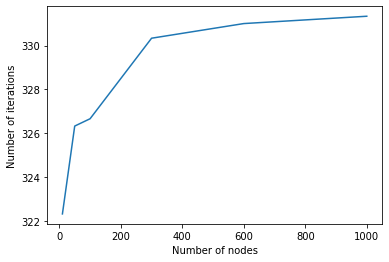

data/stronglyconvex_centralized.npy


In [15]:
topology = "centralized"
lr = 1e-2
threshold = 2e-5

means, results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp)

plotIter(num_nodes, means)

filename = save_folder + func_type.replace(" ", "") + "_" + topology + ".npy"
print(filename)

with open(filename, 'wb') as f:
    np.save(f, results)

# Plots

In [4]:
def plotError(num_nodes, data, title, names=["Centralized", "Dense", "Ring"]):
    
    plt.figure(figsize=(8, 5)) 
    
    for i, dt in enumerate(data):
        
        means = np.mean(dt, axis=1)
        std = np.std(dt, axis=1)
        
        plt.plot(num_nodes, means, label=names[i], linewidth=3)
        plt.fill_between(num_nodes, means-std, means+std, alpha=0.3)
        
    
    plt.tight_layout()
    plt.rc('xtick',labelsize=16)
    plt.rc('ytick',labelsize=16)
    plt.xlabel("Number of nodes", fontsize=18)
    plt.ylabel("Number of iterations", fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.title(title, fontsize=18)
    

## Convex

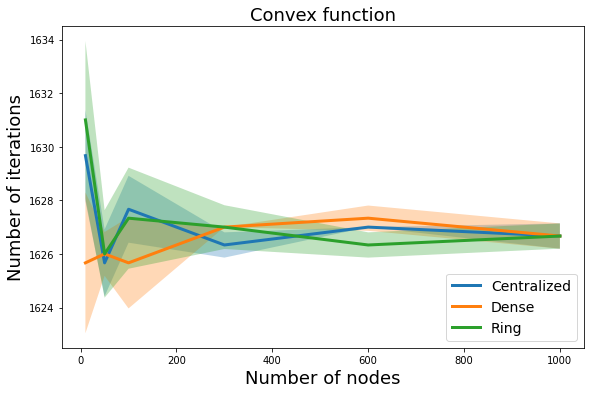

In [5]:
centralized = np.load(save_folder + "convex_centralized.npy")
dense = np.load(save_folder + "convex_dense.npy")
ring = np.load(save_folder + "convex_ring.npy")

data = [centralized, dense, ring]

plotError(num_nodes, data, "Convex function")

## Non convex

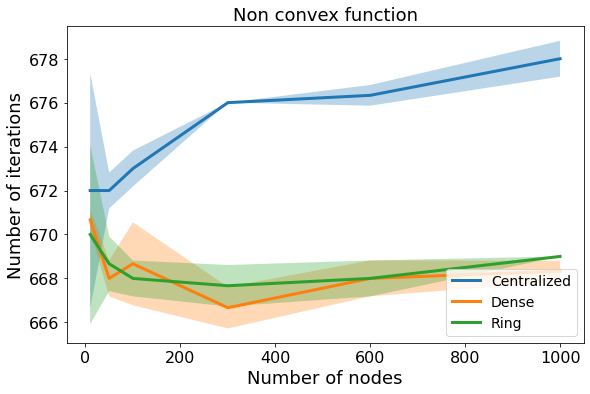

In [6]:
centralized = np.load(save_folder + "nonconvex_centralized.npy")
dense = np.load(save_folder + "nonconvex_dense.npy")
ring = np.load(save_folder + "nonconvex_ring.npy")

data = [centralized, dense, ring]

plotError(num_nodes, data, "Non convex function")

## Strongly convex

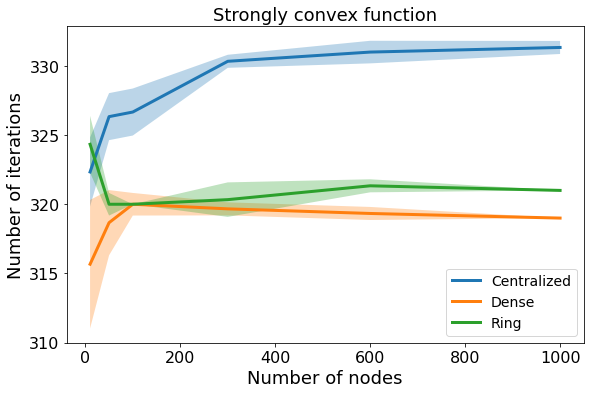

In [24]:
centralized = np.load(save_folder + "stronglyconvex_centralized.npy")
dense = np.load(save_folder + "stronglyconvex_dense.npy")
ring = np.load(save_folder + "stronglyconvex_ring.npy")

data = [centralized, dense, ring]

plotError(num_nodes, data, "Strongly convex function")